# Import

In [34]:
#   import packages
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import networkx as nx
import pickle
import functools

from ema_workbench import (
    Model,
    Policy,
    Scenario,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    util,
    ScalarOutcome,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress
from ema_workbench.em_framework import parameters_from_csv
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import prim
from ema_workbench import Samplers

Then, the model is loaded, and logging is set.

In [35]:
# initiate model
dike_model, planning_steps = get_model_for_problem_formulation(5)
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

First, the results of the policy discovery is loaded.

In [36]:
# load pareto policies
pareto_policies = pd.read_pickle(r'../generated_datasets/initial_Pareto_policies.pkl')

Then, the policies from the analysis are loaded into the model.

In [37]:
# load pareto policies into policy instances of the model
policies = []
for row_number in range(pareto_policies.shape[0]):
    policies.append(
        Policy(name=row_number, **pareto_policies.iloc[row_number, :-5].to_dict())
    )

General settings of the model are set.

In [38]:
# set number of scenarios
n_scenarios = int(10_000)

# Model run

Then, run the model with the robust policies as input, and generate results over a lot of scenarios. Commented out, as the model run is performed in the .py file (as discussed in the ReadMe).

In [ ]:
# run uncertainty analysis
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=n_scenarios,
#                                             policies=policies,
#                                             uncertainty_sampling=Samplers.LHS
#                                             )
#
# # save results to pickle file
# with open(r'../generated_datasets/policy_uncertainty_test.pkl', 'wb') as file_pi:
#     pickle.dump(results, file_pi)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 10000 scenarios * 45 policies * 1 model(s) = 450000 experiments
  0%|                                  | 163/450000 [00:16<10:34:08, 11.82it/s]

The results are then loaded in for analysis

In [39]:
# load results and split into variables
scenario_results = pd.read_pickle(r'../generated_datasets/policy_uncertainty_test.pkl')
experiments, outcomes = scenario_results
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,123,114.999161,1.5,0.097214,267.026880,10.0,0.534503,41.222939,1.5,0.074974,...,0,3,0,0,0,0,0,0,0,dikesnet
1,12,114.507209,10.0,0.539099,117.390183,1.5,0.810281,209.314732,1.0,0.011289,...,0,3,0,0,0,0,0,1,0,dikesnet
2,93,67.728956,1.0,0.518512,105.078120,10.0,0.700256,89.773865,10.0,0.407997,...,0,3,0,0,0,0,0,2,0,dikesnet
3,76,189.885408,10.0,0.381116,147.348388,1.0,0.320509,329.767171,1.0,0.035767,...,0,3,0,0,0,0,0,3,0,dikesnet
4,105,220.684581,10.0,0.822199,341.672453,10.0,0.331055,210.102760,10.0,0.801983,...,0,3,0,0,0,0,0,4,0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224995,31,289.668313,1.0,0.052410,99.791409,1.5,0.475975,117.906512,1.5,0.997902,...,0,2,0,0,0,0,0,4995,44,dikesnet
224996,69,314.054116,1.0,0.103507,181.102471,1.5,0.875119,69.791147,1.0,0.342026,...,0,2,0,0,0,0,0,4996,44,dikesnet
224997,12,199.471980,1.0,0.020007,118.888179,1.0,0.490355,325.124367,10.0,0.750680,...,0,2,0,0,0,0,0,4997,44,dikesnet
224998,65,319.848416,1.5,0.459135,97.898038,1.5,0.945095,327.164295,1.5,0.325334,...,0,2,0,0,0,0,0,4998,44,dikesnet


Make a dataframe column for every timestep of the results.

In [40]:
# move results to dataframe
policies_all_scenarios = pd.DataFrame()
for key, value in outcomes.items():
    temp_df = pd.DataFrame(value, columns=[key + ' '+ str(x) for x in range(len(value[0]))])
    policies_all_scenarios = pd.concat([policies_all_scenarios, temp_df], axis=1)

Add experiments input to the outputs for analysis

In [41]:
# combine experiments and results
experiments_and_results = pd.concat([experiments,policies_all_scenarios], axis=1)

# save to pickle file
with open(r'../generated_datasets/policy_uncertainty_experiments_results.pkl', 'wb') as file_pi:
    pickle.dump(experiments_and_results, file_pi)

Combine the variables of different dikes and times

In [42]:
def combine_columns(dataframe, name):
    """
    Function that takes in dataframe and a column name, and inserts a column of the sums of columns that include the name of the desired column.
    This happens inplace, and the function does not return anything

    Parameters
    ----------
    dataframe: dataframe with columns
    name: name of desired combined column

    """

    combined_columns = []
    for x in dataframe.columns:
        if name in x:
            combined_columns.append(x)

    dataframe['Total ' + str(name)] = dataframe[combined_columns].sum(axis=1)

In [43]:
# combine columns of variables
combine_columns(policies_all_scenarios, 'Expected Annual Damage')
combine_columns(policies_all_scenarios, 'Dike Investment Costs')
combine_columns(policies_all_scenarios, 'Expected Number of Deaths')
combine_columns(policies_all_scenarios, 'RfR Total Costs')
combine_columns(policies_all_scenarios, 'Expected Evacuation Costs')

Generate statistics

In [44]:
aggregated_outcomes = pd.concat([experiments[['scenario','policy']],policies_all_scenarios.iloc[:,-5:]], axis=1)

# generate statistics mean and std
stats_df = pd.DataFrame()
for column in aggregated_outcomes.iloc[:,2:].columns:
    stats_df[column + ' mean'] = aggregated_outcomes.groupby('policy').agg({column:['mean']})
    stats_df[column + ' std'] = aggregated_outcomes.groupby('policy').agg({column:['std']})

# save to pickle file
with open(r'../generated_datasets/policy_uncertainty_aggregated.pkl', 'wb') as file_pi:
    pickle.dump(aggregated_outcomes, file_pi)

Load results from Uncertainty Analysis

In [45]:
# load pickle files into variables
uncertainty_results = pd.read_pickle(r'../generated_datasets/policy_uncertainty_provinces.pkl')
experiments_and_results = pd.read_pickle(r'../generated_datasets/policy_uncertainty_experiments_results.pkl')
aggregated_outcomes = pd.read_pickle(r'../generated_datasets/policy_uncertainty_aggregated.pkl')
uncertainty_results_run = pd.read_pickle(r'../generated_datasets/policy_uncertainty_test.pkl')

# Calculate Robustness Metrics

First, the time data is combined into a single value, and saved into a DataFrame.

In [46]:
experiments, outcomes = uncertainty_results_run

# combine time data to single column
results_df = pd.DataFrame()
for k in outcomes:
    test_list = []
    for i in range(len(experiments)):
        t = outcomes[k][i].sum()
        test_list.append(t)
    results_df[k]=test_list

Then, we calculate the cost of death for all death columns, making it able to easily construct a total cost.

In [47]:
death_cost_per_person = 6_300_000

# calculate the cost of death so every column has the same unit (€)
results_df["A.1_Deaths_Cost"]=results_df["A.1_Expected Number of Deaths"]*death_cost_per_person
results_df["A.2_Deaths_Cost"]=results_df["A.2_Expected Number of Deaths"]*death_cost_per_person
results_df["A.3_Deaths_Cost"]=results_df["A.3_Expected Number of Deaths"]*death_cost_per_person
results_df["A.4_Deaths_Cost"]=results_df["A.4_Expected Number of Deaths"]*death_cost_per_person
results_df["A.5_Deaths_Cost"]=results_df["A.5_Expected Number of Deaths"]*death_cost_per_person

# drop unnecessary columns
to_drop = ["A.1_Expected Number of Deaths","A.2_Expected Number of Deaths","A.3_Expected Number of Deaths","A.4_Expected Number of Deaths","A.5_Expected Number of Deaths"]
results_df.drop(to_drop, axis=1, inplace=True)

### Gelderland - Overijssel Split

A function is created to sort the data into two columns: Gelderland and Overijssel.

In [48]:
def combine_columns_province(dataframe, name):
    """
    Function that takes in dataframe and a column name, and inserts two columns of the sums of columns that include the name of the desired column, split into provinces Gelderland and Overijssel.
    This happens inplace, and the function does not return anything

    Parameters
    ----------
    dataframe: dataframe with columns
    name: name of desired combined column

    """

    combined_columns_gelderland = []
    combined_columns_overijssel = []
    for x in dataframe.columns:
        if name in x:
            if x.startswith('A.1') or x.startswith('A.2') or x.startswith('A.3'):
                combined_columns_gelderland.append(x)
            if x.startswith('A.4') or x.startswith('A.5'):
                combined_columns_overijssel.append(x)

    dataframe['Total ' + str(name) + ' Gelderland'] = dataframe[combined_columns_gelderland].sum(axis=1)
    dataframe['Total ' + str(name) + ' Overijssel'] = dataframe[combined_columns_overijssel].sum(axis=1)

A new DataFrame is then created with the province-sorted data.

In [49]:
provinces = results_df.copy()

# combine the columns of the variables
combine_columns_province(provinces, 'Expected Annual Damage')
combine_columns_province(provinces, 'Dike Investment Costs')
combine_columns_province(provinces, 'Deaths_Cost')

The excess columns are then deleted, and columns are created with total cost and total cost for the province of Overijssel.

In [50]:
# combine experiments number and policy number and outcomes
aggregated_outcomes_provinces = pd.concat([experiments[['scenario','policy']],provinces], axis=1).iloc[:,2:]

# drop non-aggregated columns
for x in aggregated_outcomes_provinces.columns:
        if x.startswith('A.1') or x.startswith('A.2') or x.startswith('A.3') or x.startswith('A.4') or x.startswith('A.5'):
            aggregated_outcomes_provinces.drop(x, axis=1, inplace=True)
        else:
            pass

# generate sum variables
aggregated_outcomes_provinces['total_cost[€]']= aggregated_outcomes_provinces.sum(axis=1)
overijssel_sum = ['RfR Total Costs','Expected Evacuation Costs','Total Expected Annual Damage Overijssel','Total Dike Investment Costs Overijssel','Total Deaths_Cost Overijssel']
aggregated_outcomes_provinces['total_cost[€]_overijssel']= aggregated_outcomes_provinces.loc[:,overijssel_sum].sum(axis=1)

Lastly, we add the policy number.

In [51]:
# add policy number
aggregated_outcomes_provinces_policy = aggregated_outcomes_provinces.copy()
aggregated_outcomes_provinces_policy['policy'] = experiments.iloc[:,-2]

# save to pickle file
with open(r'..\generated_datasets\policy_all_scenarios.pkl','wb') as pickle_file:
    pickle.dump(aggregated_outcomes_provinces_policy, pickle_file)

# Generate outcome optimal for Overijssel

The best 5 (cheapest) policies are selected. For this, we need the robustness metric again: Mean Square Deviation. For this, we construct a function that makes the column.

In [52]:
def mean_square_deviation(df_input, df_output, column_name):
    """
    Function that takes in a dataframe, and returns the mean square deviation of a desired column for each group of the grouping into a new dataframe.
    This happens inplace, the function does not return anything.

    Parameters
    ----------
    df_input: dataframe with columns of values
    df_output: dataframe for output
    column_name: desired column for which the mean square deviation is calculated.

    """

    grouping = df_input.groupby(['policy']).agg({column_name:['mean', 'std']})
    df_output['MSD ' + column_name] = np.square(grouping[(column_name, 'mean')]) + np.square(grouping[(column_name, 'std')])
    grouping.drop([(column_name, 'mean'), (column_name, 'std')], axis=1, inplace=True)

The robustness metric of the policies is calculated and stored in a DataFrame for comparison.

In [53]:
robust_df = pd.DataFrame()

# calculate robustness metrics for variables
mean_square_deviation(aggregated_outcomes_provinces_policy, robust_df, 'RfR Total Costs')
mean_square_deviation(aggregated_outcomes_provinces_policy, robust_df, 'Expected Evacuation Costs')
mean_square_deviation(aggregated_outcomes_provinces_policy, robust_df, 'Total Expected Annual Damage Overijssel')
mean_square_deviation(aggregated_outcomes_provinces_policy, robust_df, 'Total Dike Investment Costs Overijssel')
mean_square_deviation(aggregated_outcomes_provinces_policy, robust_df, 'Total Deaths_Cost Overijssel')

The top 5 policies are determined and stored.

In [65]:
# generate mean and std
grouping = aggregated_outcomes_provinces_policy.groupby(['policy']).agg({'total_cost[€]_overijssel':['mean', 'std']})
# generate robustness metric of total cost overijssel
grouping[('total_cost[€]_overijssel','mean square deviation')] = np.square(grouping[('total_cost[€]_overijssel', 'mean')]) + np.square(grouping[('total_cost[€]_overijssel', 'std')])

In [66]:
n_scenarios_of_interest = 5

# save 5 best policies
results_of_interest_overijssel = grouping.sort_values(by=('total_cost[€]_overijssel','mean square deviation'), ascending=True).head(n_scenarios_of_interest)
with open(r'..\generated_datasets\final_policies_overijssel.pkl','wb') as pickle_file:
    pickle.dump(results_of_interest_overijssel, pickle_file)

results_of_interest_overijssel

total_cost[€]_overijssel                                    
                           mean           std mean square deviation
policy                                                             
26                 8.331391e+07  1.933501e+08          4.432547e+16
11                 8.407651e+07  1.934453e+08          4.448995e+16
5                  1.760816e+08  1.291865e+08          4.769388e+16
44                 1.763057e+08  1.298316e+08          4.793996e+16
9                  1.764013e+08  1.300868e+08          4.803999e+16

### Visualization

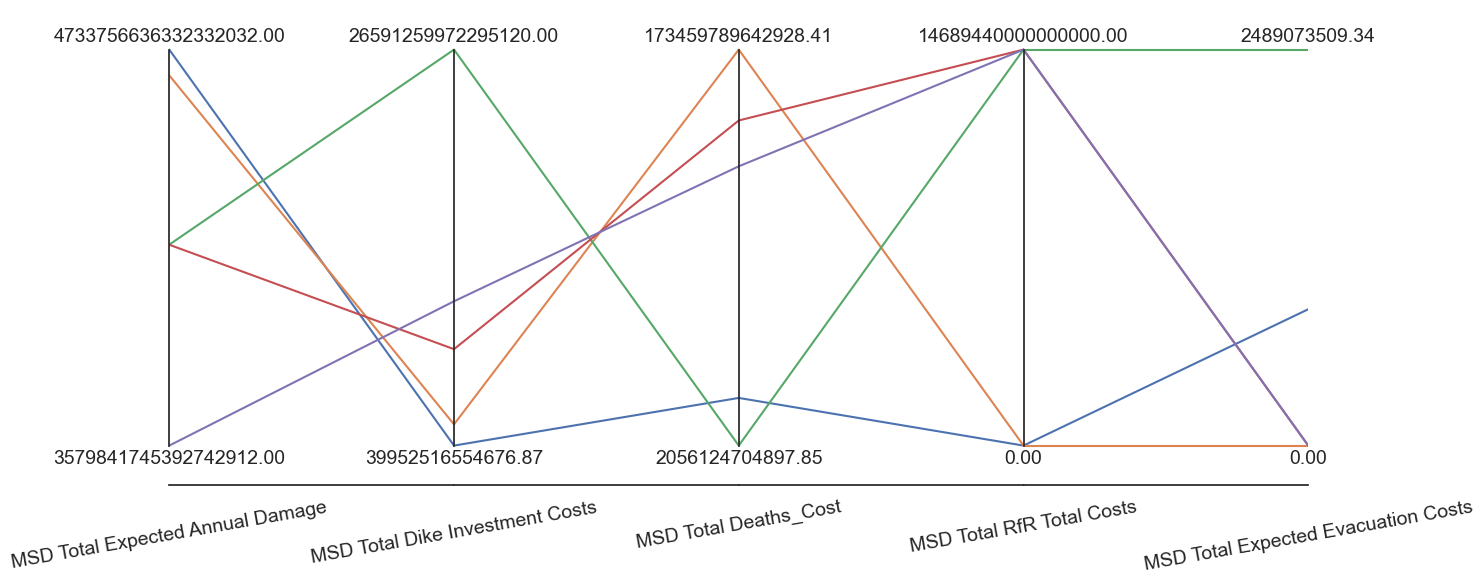

In [67]:
# visualize 5 best policy robustness metrics
data = robust_df.iloc[results_of_interest_overijssel.index.values]
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits, rot=10)
paraxes.plot(data)
sns.despine()
plt.savefig(r'../visualizations/Scenario_Discovery/pareto_visualization_overijssel.png', bbox_inches='tight')
sns.set(rc={'figure.figsize': (15, 6)})

# Generate outcome optimal for Gelderland and Overijssel combined.

The same is done for the total cost of the provinces of Gelderland and Overijssel combined.

In [ ]:
robust_df = pd.DataFrame()

# generate death cost variable
aggregated_outcomes['Total Deaths_Cost'] = aggregated_outcomes['Total Expected Number of Deaths']*death_cost_per_person

# generate robustness metric outcomes of variables
mean_square_deviation(aggregated_outcomes, robust_df, 'Total Expected Annual Damage')
mean_square_deviation(aggregated_outcomes, robust_df, 'Total Dike Investment Costs')
mean_square_deviation(aggregated_outcomes, robust_df, 'Total Deaths_Cost')
mean_square_deviation(aggregated_outcomes, robust_df, 'Total RfR Total Costs')
mean_square_deviation(aggregated_outcomes, robust_df, 'Total Expected Evacuation Costs')

The top 5 is determined and stored.

In [73]:
# generate robustness metric of total cost
grouping = aggregated_outcomes_provinces_policy.groupby(['policy']).agg({'total_cost[€]':['mean', 'std']})
grouping[('total_cost[€]','mean square deviation')] = np.square(grouping[('total_cost[€]', 'mean')]) + np.square(grouping[('total_cost[€]', 'std')])

In [74]:
n_scenarios_of_interest = 5

# save top 5 policies
results_of_interest = grouping.sort_values(by=('total_cost[€]','mean square deviation'), ascending=True).head(n_scenarios_of_interest)
with open(r'..\generated_datasets\final_policies.pkl','wb') as pickle_file:
    pickle.dump(results_of_interest, pickle_file)

results_of_interest

total_cost[€]                                    
                mean           std mean square deviation
policy                                                  
36      1.033884e+09  7.140469e+08          1.578779e+18
2       1.181345e+09  7.133925e+08          1.904505e+18
10      1.373723e+09  9.660506e+08          2.820368e+18
25      1.422984e+09  9.787605e+08          2.982856e+18
1       1.481486e+09  8.880334e+08          2.983405e+18

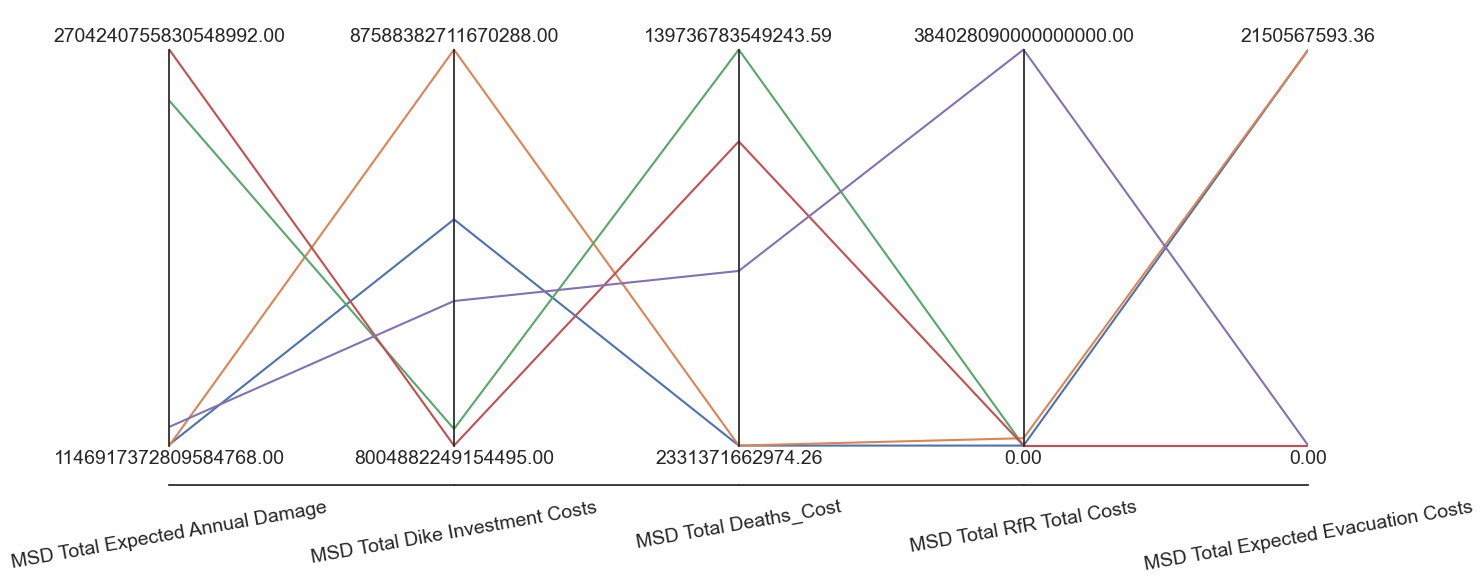

In [75]:
# visualize top 5 policies
data = robust_df.iloc[results_of_interest.index.values]
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits, rot=10)
paraxes.plot(data)
sns.despine()
plt.savefig(r'../visualizations/Scenario_Discovery/pareto_visualization.png', bbox_inches='tight')
sns.set(rc={'figure.figsize': (15, 6)})

# Final policies

### Top 5 policies Overijssel:

In [76]:
# show levers of top 5 policies
policies = pd.read_pickle(r'../generated_datasets/initial_Pareto_policies.pkl')
policies.iloc[results_of_interest_overijssel.index.values].T

,26,11,5,44,9
0_RfR 0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0_RfR 1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0_RfR 2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1_RfR 0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1_RfR 1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1_RfR 2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2_RfR 0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2_RfR 1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2_RfR 2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3_RfR 0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00


### Top 5 policies Gelderland and Overijssel combined:

In [77]:
# show levers of top 5 policies
policies = pd.read_pickle(r'../generated_datasets/initial_Pareto_policies.pkl')
policies.iloc[results_of_interest.index.values].T

,36,2,10,25,1
0_RfR 0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0_RfR 1,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0_RfR 2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1_RfR 0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1_RfR 1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1_RfR 2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2_RfR 0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2_RfR 1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2_RfR 2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3_RfR 0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
